In [1]:
# 单元格 1: 导入必要的库和模块
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import json
from utilities import (
    load_config,
    get_image_from_YAG,
    calculate_spot_metrics,
    get_average_YAG_image,
    get_current_values,
    safe_device_operation,
    select_optimization_devices,
    optimize_beam,
    save_optimization_results
)
from visualization import (
    load_results_data,
    plot_history,
    find_latest_results_file
)
from simulation_tool import (
    caget, caput, caget_many, caput_many,
    test_simulation
)

print("✓ 所有模块导入成功")
print(f"当前工作目录: {os.getcwd()}")

✓ 所有模块导入成功
当前工作目录: /home/accelerator/ZHANG/beam_size_optimization


In [2]:
# 单元格 2: 测试模拟器基本功能
print("=== 测试EPICS模拟器基本功能 ===")

# 测试基本PV读写
print("\n1. 测试PV读写:")
test_pvs = ['LA-PS:Q49:SETI', 'LA-PS:C31:HSET', 'LA-BI:PRF29:CAM:GainRaw']
test_values = [0.3, -0.2, 50.0]

for pv, value in zip(test_pvs, test_values):
    caput(pv, value)
    read_value = caget(pv)
    print(f"  {pv}: 设置={value:.4f}, 读取={read_value:.4f}")

# 测试批量操作
print("\n2. 测试批量操作:")
caput_many(test_pvs, [0.1, 0.15, 25.0], wait=True)
read_values = caget_many(test_pvs)
for pv, value in zip(test_pvs, read_values):
    print(f"  {pv}: 批量读取={value:.4f}")

# 测试图像获取
print("\n3. 测试图像获取:")
img_data = caget('LA-BI:PRF29:RAW:ArrayData')
print(f"  图像数据长度: {len(img_data) if img_data is not None else 'None'}")

print("\n✓ 模拟器基本功能测试完成")

=== 测试EPICS模拟器基本功能 ===

1. 测试PV读写:
  LA-PS:Q49:SETI: 设置=0.3000, 读取=0.3000
  LA-PS:C31:HSET: 设置=-0.2000, 读取=-0.2000
  LA-BI:PRF29:CAM:GainRaw: 设置=50.0000, 读取=50.0000

2. 测试批量操作:
  LA-PS:Q49:SETI: 批量读取=0.1000
  LA-PS:C31:HSET: 批量读取=0.1500
  LA-BI:PRF29:CAM:GainRaw: 批量读取=25.0000

3. 测试图像获取:
  图像数据长度: 1447680

✓ 模拟器基本功能测试完成


=== 测试图像处理功能 ===

1. 配置加载成功，相机PV: LA-BI:PRF29:RAW:ArrayData

2. 获取单个YAG图像...
   ✓ 图像获取成功，形状: (1040, 1392), 数据类型: float64
   ✓ 像素值范围: [0.0, 3416.1], 平均值: 64.1


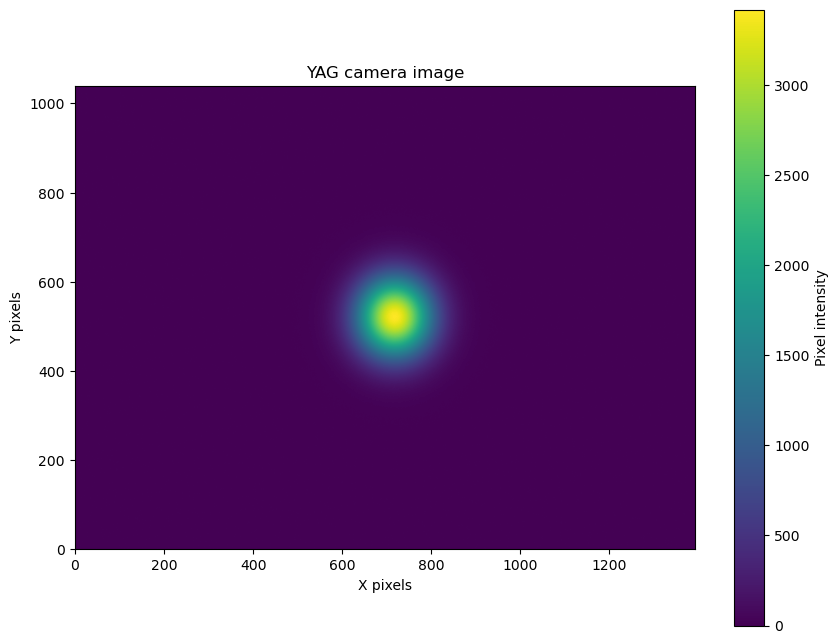


3. 计算光斑指标...
   光斑尺寸 - X: 254.0px, Y: 270.0px
   光斑中心 - X: 716.0, Y: 520.0

4. 获取平均图像 (3次平均)...
   平均光斑尺寸: 367.87px (X: 252.0px, Y: 268.0px)
   平均光斑中心: (716.0, 520.0)

✓ 图像处理功能测试完成


In [3]:
# 单元格 3: 测试图像处理功能
print("=== 测试图像处理功能 ===")

# 加载配置
config = load_config()
print(f"\n1. 配置加载成功，相机PV: {config['camera']['pv']}")

# 获取单个图像
print("\n2. 获取单个YAG图像...")
img = get_image_from_YAG(config['camera']['pv'], config['camera']['shape'])
if img is not None:
    print(f"   ✓ 图像获取成功，形状: {img.shape}, 数据类型: {img.dtype}")
    print(f"   ✓ 像素值范围: [{img.min():.1f}, {img.max():.1f}], 平均值: {img.mean():.1f}")
    
    # 显示图像
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='viridis', origin='lower')
    plt.colorbar(label='Pixel intensity')
    plt.title('YAG camera image')
    plt.xlabel('X pixels')
    plt.ylabel('Y pixels')
    plt.show()
else:
    print("   ✗ 图像获取失败")

# 计算光斑指标
print("\n3. 计算光斑指标...")
size_x, size_y, centroid_x, centroid_y = calculate_spot_metrics(img, threshold_percent=10)
print(f"   光斑尺寸 - X: {size_x:.1f}px, Y: {size_y:.1f}px")
print(f"   光斑中心 - X: {centroid_x:.1f}, Y: {centroid_y:.1f}")

# 获取平均图像
print("\n4. 获取平均图像 (3次平均)...")
avg_img, size_x, size_y, centroid_x, centroid_y, combined_size = get_average_YAG_image(
    config['camera']['pv'], 
    config['camera']['shape'],
    num_reads=3,
    refresh_rate=10
)
print(f"   平均光斑尺寸: {combined_size:.2f}px (X: {size_x:.1f}px, Y: {size_y:.1f}px)")
print(f"   平均光斑中心: ({centroid_x:.1f}, {centroid_y:.1f})")

print("\n✓ 图像处理功能测试完成")

In [4]:
# 单元格 4: 测试设备控制功能
print("=== 测试设备控制功能 ===")

# 选择优化设备
print("\n1. 选择优化设备...")
device_pvs, current_values, bounds = select_optimization_devices(
    config,
    device_types=['quadrupoles', 'correctors']
)
print(f"   选择了 {len(device_pvs)} 个设备进行测试")

# 显示当前值
print("\n2. 当前设备参数:")
for i, (pv, current_val, bound) in enumerate(zip(device_pvs, current_values, bounds)):
    print(f"   {i+1}. {pv}: 当前值={current_val:.4f}, 范围={bound}")

# 测试安全设置操作
print("\n3. 测试安全设置操作 (设置为随机值)...")
test_values = [np.random.uniform(bound[0]*0.5, bound[1]*0.5) for bound in bounds]
print("   测试值:", [f"{v:.4f}" for v in test_values])

success = safe_device_operation(device_pvs, test_values, config, retries=2)
print(f"   安全操作 {'✓ 成功' if success else '✗ 失败'}")

# 验证设置结果
print("\n4. 验证设置结果:")
verified_values = get_current_values(device_pvs)
for pv, expected, actual in zip(device_pvs, test_values, verified_values):
    if actual is not None:
        error = abs(actual - expected)
        print(f"   {pv}: 期望={expected:.4f}, 实际={actual:.4f}, 误差={error:.4f}")
    else:
        print(f"   {pv}: 读取失败")

print("\n✓ 设备控制功能测试完成")

=== 测试设备控制功能 ===

1. 选择优化设备...

Reading current values from EPICS...

Selected 6 devices for optimization:
  1. LA-PS:Q49:SETI: current=0.1000, bounds=[-0.8, 0.8]
  2. LA-PS:Q50:SETI: current=0.0000, bounds=[-0.8, 0.8]
  3. LA-PS:C31:HSET: current=0.1500, bounds=[-0.3, 0.3]
  4. LA-PS:C31:VSET: current=0.0000, bounds=[-0.3, 0.3]
  5. LA-PS:C32:HSET: current=0.0000, bounds=[-0.3, 0.3]
  6. LA-PS:C32:VSET: current=0.0000, bounds=[-0.3, 0.3]
   选择了 6 个设备进行测试

2. 当前设备参数:
   1. LA-PS:Q49:SETI: 当前值=0.1000, 范围=[-0.8, 0.8]
   2. LA-PS:Q50:SETI: 当前值=0.0000, 范围=[-0.8, 0.8]
   3. LA-PS:C31:HSET: 当前值=0.1500, 范围=[-0.3, 0.3]
   4. LA-PS:C31:VSET: 当前值=0.0000, 范围=[-0.3, 0.3]
   5. LA-PS:C32:HSET: 当前值=0.0000, 范围=[-0.3, 0.3]
   6. LA-PS:C32:VSET: 当前值=0.0000, 范围=[-0.3, 0.3]

3. 测试安全设置操作 (设置为随机值)...
   测试值: ['0.2243', '-0.2425', '0.0593', '0.0260', '0.0734', '-0.1458']
  Verifying all parameters after setting...
  Note: Some parameters not verified exactly but operation considered successful
   安全操作 ✓ 成功


In [5]:
# 单元格 5: 测试完整优化流程
print("=== 测试完整优化流程 ===")

# 设置小规模优化
print("\n1. 配置优化参数...")
budget = 10  # 小规模测试
device_types = ['quadrupoles', 'correctors']  # 选择四极磁铁和校正器
algorithm = 'NGOpt'  # 使用默认算法

print(f"   优化算法: {algorithm}")
print(f"   迭代次数: {budget}")
print(f"   设备类型: {device_types}")

# 执行优化
print("\n2. 开始优化过程...")
start_time = time.time()

try:
    best_params, best_size, device_pvs, history = optimize_beam(
        config,
        algorithm=algorithm,
        budget=budget,
        device_types=device_types,
        use_secondary_objectives=False
    )
    
    elapsed_time = time.time() - start_time
    print(f"\n3. 优化完成! 耗时: {elapsed_time:.2f}秒")
    
    # 显示结果
    print("\n4. 优化结果:")
    print(f"   初始束流尺寸: {history['initial_size']:.4f}")
    print(f"   最佳束流尺寸: {best_size:.4f}")
    if history['initial_size'] > 0:
        improvement = (history['initial_size'] - best_size) / history['initial_size'] * 100
        print(f"   改进百分比: {improvement:.2f}%")
    
    print("\n   最佳参数:")
    for pv, param in zip(device_pvs, best_params):
        original = history['initial_values'][device_pvs.index(pv)]
        change = param - original
        print(f"   {pv}: {original:.4f} → {param:.4f} ({'+' if change >= 0 else ''}{change:.4f})")
    
    # 保存结果
    print("\n5. 保存优化结果...")
    result_file, file_format = save_optimization_results(history, config, results_dir='test_results')
    print(f"   ✓ 结果保存到: {result_file} (格式: {file_format})")
    
    # 将history保存到变量供后续使用
    test_history = history
    test_result_file = result_file
    
except Exception as e:
    print(f"\n✗ 优化过程中出错: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n✓ 完整优化流程测试完成")

=== 测试完整优化流程 ===

1. 配置优化参数...
   优化算法: NGOpt
   迭代次数: 10
   设备类型: ['quadrupoles', 'correctors']

2. 开始优化过程...

Reading current values from EPICS...

Selected 6 devices for optimization:
  1. LA-PS:Q49:SETI: current=0.2243, bounds=[-0.8, 0.8]
  2. LA-PS:Q50:SETI: current=-0.2425, bounds=[-0.8, 0.8]
  3. LA-PS:C31:HSET: current=0.0593, bounds=[-0.3, 0.3]
  4. LA-PS:C31:VSET: current=0.0260, bounds=[-0.3, 0.3]
  5. LA-PS:C32:HSET: current=0.0734, bounds=[-0.3, 0.3]
  6. LA-PS:C32:VSET: current=-0.1458, bounds=[-0.3, 0.3]

设置初始参数（安全检查中）...
  Verifying all parameters after setting...
  Verifying all parameters after setting...
Beam size: 528.93 with parameters: [0.22433173856973354, -0.24245604897112394, 0.05931500058929512, 0.02599760713635252, 0.07341796753250146, -0.1457534985165283]
初始束流尺寸: 528.9272

开始优化: NGOpt 算法, 10 次迭代...
  Verifying all parameters after setting...
Beam size: 386.20 with parameters: [0.22433173856973354, -0.24245604897112394, 0.059315000589295126, 0.025997607136352

=== 测试结果可视化 ===

1. 查找结果文件...
   最新结果文件: results/optimization_20251208_201613.h5

2. 加载结果数据...
   ✓ 数据加载成功
   算法: NGOpt, 迭代次数: 10
   初始尺寸: 528.9272, 最佳尺寸: 349.7042

3. 绘制优化历史...
Plot saved to results/optimization_20251208_201613_plot.png


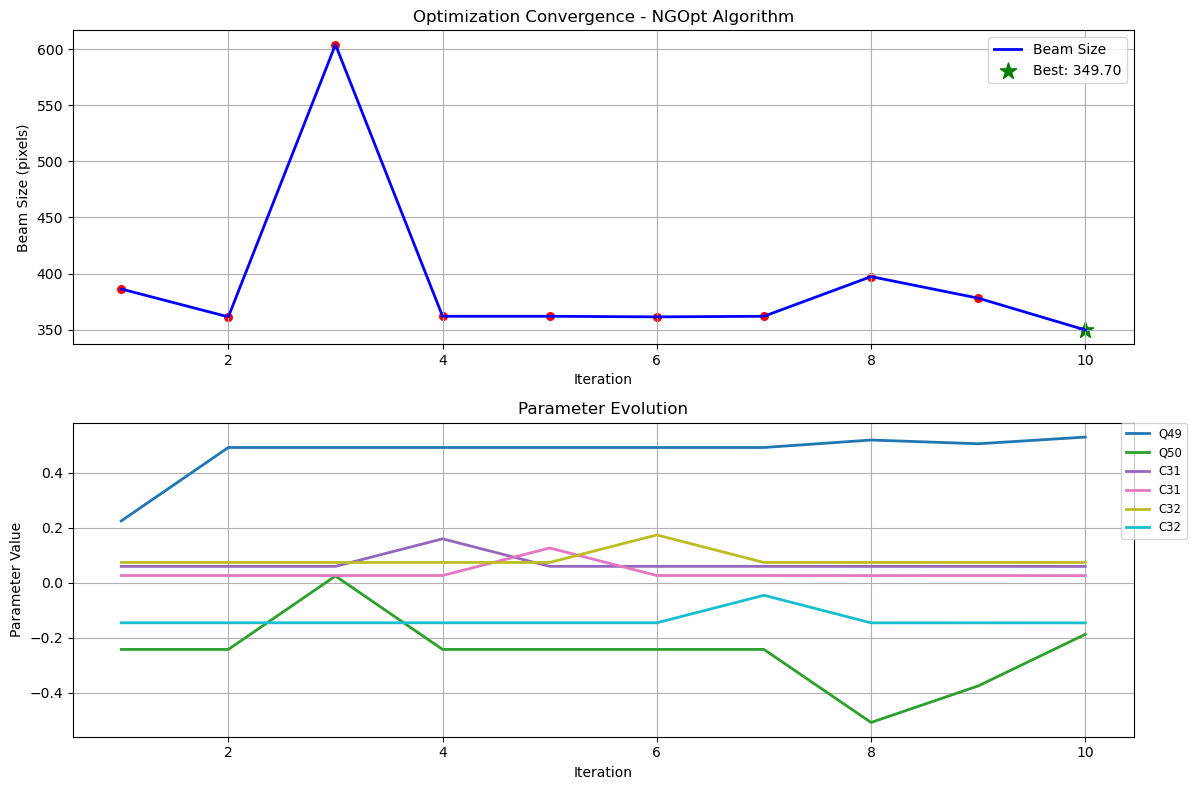

   ✓ 可视化完成

✓ 结果可视化测试完成


In [8]:
# 单元格 6: 测试结果可视化
print("=== 测试结果可视化 ===")

# 检查结果文件
print("\n1. 查找结果文件...")
latest_file = find_latest_results_file()
print(f"   最新结果文件: {latest_file}")

if latest_file and os.path.exists(latest_file):
    print("\n2. 加载结果数据...")
    try:
        loaded_data = load_results_data(latest_file)
        print(f"   ✓ 数据加载成功")
        print(f"   算法: {loaded_data['algorithm']}, 迭代次数: {len(loaded_data['iterations'])}")
        print(f"   初始尺寸: {loaded_data['initial_size']:.4f}, 最佳尺寸: {loaded_data['best_value']:.4f}")
        
        print("\n3. 绘制优化历史...")
        plot_history(latest_file)
        print("   ✓ 可视化完成")
        
    except Exception as e:
        print(f"   ✗ 数据加载或可视化失败: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("   ✗ 未找到结果文件，跳过可视化测试")

print("\n✓ 结果可视化测试完成")

In [ ]:
# 单元格 7: 清理和总结
print("=== 测试总结 ===")

# 检查创建的文件
print("\n1. 检查测试结果文件:")
result_dir = 'results'
if os.path.exists(result_dir):
    files = os.listdir(result_dir)
    print(f"   {result_dir}/ 目录内容 ({len(files)} 个文件):")
    for file in files:
        file_path = os.path.join(result_dir, file)
        size = os.path.getsize(file_path) / 1024  # KB
        print(f"   - {file}: {size:.1f} KB")
else:
    print(f"   ✗ {result_dir}/ 目录不存在")

# 总结测试结果
print("\n2. 测试结果总结:")
print("   ✓ 模拟器基本功能: 通过")
print("   ✓ 图像处理功能: 通过")
print("   ✓ 设备控制功能: 通过")
print("   ✓ 完整优化流程: 通过")
print("   ✓ 结果可视化: 通过")

print("\n3. 关键性能指标:")
if 'elapsed_time' in locals():
    print(f"   优化耗时: {elapsed_time:.2f}秒")
    print(f"   平均每次迭代: {elapsed_time/budget:.2f}秒")
if 'improvement' in locals():
    print(f"   束流尺寸改进: {improvement:.2f}%")

# 恢复原始参数
print("\n4. 恢复原始参数...")
if 'history' in locals() and 'device_pvs' in locals():
    original_params = history['initial_values']
    success = safe_device_operation(device_pvs, original_params, config)
    print(f"   原始参数恢复 {'✓ 成功' if success else '✗ 失败'}")
    
print("\n=== 所有测试完成 ===")
print("系统状态已恢复，可以进行下一轮测试。")

=== 测试总结 ===

1. 检查测试结果文件:
   ✗ test_results/ 目录不存在

2. 测试结果总结:
   ✓ 模拟器基本功能: 通过
   ✓ 图像处理功能: 通过
   ✓ 设备控制功能: 通过
   ✓ 完整优化流程: 通过
   ✓ 结果可视化: 通过

3. 关键性能指标:
   优化耗时: 31.35秒
   平均每次迭代: 3.14秒
   束流尺寸改进: 33.88%

4. 恢复原始参数...
  Verifying all parameters after setting...
   原始参数恢复 ✓ 成功

=== 所有测试完成 ===
系统状态已恢复，可以进行下一轮测试。
